## IMPORTING PACKAGES

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import preprocessing
import visualization
import utils
from easydict import EasyDict

## DATA PREPROCESSING

In [4]:
# Training and testing names are given by a variable named 'splits'
from utils import splits

data = {}; data_test = {}
name = ['0zt','8zt','16zt'] # Folders name
for n in name:
    data, data_test = preprocessing.generate_signal_dictionary(data, data_test, scale = False, outlier_filter = False, data_splits = splits, name=n)
    
print(f'There are {len(data)} recordings used for training and {len(data_test)} recordings used for testing')

There are 3 recordings used for training and 3 recordings used for testing


In [5]:
window_size = 1024
hop_length = 1024

In [57]:
df, l = preprocessing.generate_model_data(data_dictionary=data, method = 'fft', window_size = window_size, hop_length= hop_length, verbose = True)
df_test, l_test = preprocessing.generate_model_data(data_dictionary=data_test, method = 'fft', window_size = window_size, hop_length= hop_length, verbose = True)

Signal processing method: raw
Data shape: (10651, 1024)
Class distribution (label/n_obs): 1: 369, 2: 1625, 4: 401, 5: 4973, 6: 1129, 8: 2154
Signal processing method: raw
Data shape: (9136, 1024)
Class distribution (label/n_obs): 1: 1025, 2: 642, 4: 308, 5: 6214, 6: 289, 8: 658


In [65]:
X = utils.get_one_level_split(df,l)
y = utils.get_one_level_split(df_test,l_test)

# TRAINING

In [63]:
from train import Trainer
from models import CNN1D

In [71]:
info = EasyDict({'device': 'cuda', ' n_classes': 7, 'num_epochs': 50, 'learning_rate': 0.0001,'batch_size': 64,'model_type':'cnn'})
model = CNN1D(seq_length = df.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

trainer = Trainer(X,y,model,criterion,optimizer,info)
trainer.get_loader()
trainer.train()
trainer.save_checkpoint('CNN - fft - 1024-256 - 10-01-24.pth')

Obtaning data loaders...
Train, validate, test lengths: (8520, 2131, 9136)
Input shape: torch.Size([64, 1, 1024])
Initialize...
Training...
Epoch [1/50], loss: 1.5046, validation accuracy: 0.7640
Epoch [11/50], loss: 1.2989, validation accuracy: 0.8362
Epoch [21/50], loss: 1.2737, validation accuracy: 0.8832
Epoch [31/50], loss: 1.2503, validation accuracy: 0.8897
Epoch [41/50], loss: 1.2419, validation accuracy: 0.8977
Epoch [50/50], loss: 1.2403, validation accuracy: 0.8954
Testing...
Accuracy : 0.8173
Balanced accuracy: 0.5832
Predicted labels: (array([1, 2, 3, 5, 6], dtype=int64), array([ 806,  136,  177,  683, 7334], dtype=int64))
True labels: (array([0, 1, 2, 3, 5, 6], dtype=int64), array([1025,  642,  308,  289,  658, 6214], dtype=int64))

Finished!


# PREDICTING

In [ ]:
from test import Classifier
from models import CNN1D

models = [CNN1D(), CNN1D()]
path = ['CNN2D - 1024-1024 - level1 - 10-01-2024.pth','CNN2D - 1024-1024 - level2 - 10-01-2024.pth']
device = 'cuda'

test_configs = EasyDict({'method':'spec_img', 'model_type':'cnn','scope':4, 'window_size':1024, 'hop_length':256})
clf = Classifier(models, device)
clf.load_checkpoint(path)
clf.load_configs(test_configs)

In [44]:
name = ['0zt','8zt','16zt']
acc = []
b_acc = []
for n in name:
    for fn in splits[n][1]:
        print(fn)
        wave_array,ana = data_test[fn]
        clf.predict(wave_array, ana)
        acc.append(clf.acc)
        b_acc.append(clf.b_acc)

Single level classifier
Accuracy:  0.98
Balanced accuracy:  0.75
[[  48    4    0    3    0    0]
 [   0  496    0    3   10    0]
 [   1    7   64   11    0    0]
 [   1   21   16 8742    0    0]
 [  56   62    0   69 1623    0]
 [   0    9    0    1    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.98
Balanced accuracy:  0.68
[[1013   46    0   10    0    0    0]
 [   2  865    4   20    6    0    0]
 [   0   35   44    3    0    4    0]
 [   2   13    2 9118    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0   57    0    3    0    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.91
Balanced accuracy:  0.7
[[ 427    5    0   23    0    0    0]
 [   0 2735   32   16   12    3    0]
 [   1  215  605  150    3    1    0]
 [  53  182   61 6475   17    1    0]
 [   0    0    0    0    0    0    0]
 [   0    8    0    0    0   21    0]
 [   0  190    0    3    8    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.65
Balanced accuracy:  0.57
[[ 185    5    0    4    4    0]
 [   0  286    0    1    0    0]
 [   3   10    6    2    0    0]
 [3908   20    1 6781    0    0]
 [   0    0    0    0    0    0]
 [   0   29    0    0    2    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.97
Balanced accuracy:  0.71
[[ 142    3    0    3    0    0    0]
 [   0  946   36   46   10    3    0]
 [   0    0   11   12    1    0    0]
 [   2  105    8 8197    4    0    0]
 [   0    0    0    0    0    0    0]
 [   0   30    0   63    0 1579    0]
 [   1   40    0    1    4    0    0]]
Single level classifier
Accuracy:  0.89
Balanced accuracy:  0.73
[[ 377   24    0   53    0    0    0]
 [   0 3793    4   21   38    1    0]
 [   0  134  506   67    0   12    0]
 [   0   51   62 1253    3    0    0]
 [  19  162   12   46 3026    4    0]
 [   0  345    1   41    9 1051    0]
 [   0  129    0    2    1    0    0]]
Single level classifier
Accuracy:  0.93
Balanced accuracy:  0.78
[[ 498   25    1   10    0    0    0]
 [   0 2854   16   28  126    2    0]
 [   2  105  650  146    3   18    0]
 [   0   41   88 2019    2    0    0]
 [   0   31    0   15 3586    3    0]
 [   0   30    3    9    0  870    0]
 [   0   60    0    5    1    0    0]]
Single level classifier
Accu

C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.97
Balanced accuracy:  0.63
[[ 222    7    0   12    0    0    0]
 [   0  735    0    4    7    1    0]
 [   0    5   15    0    0    0    0]
 [   4    3   14 9952    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0   86  117    0    5   37    0]
 [   0   19    0    0    2    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.88
Balanced accuracy:  0.75
[[1160   26    2  107    7    5    0]
 [  42 2817   64   12   15    5    0]
 [  17   70  669   43    1    0    0]
 [ 667   52  133 4555    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    5    4    5    0  724    0]
 [   1   37    0    2    0    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.92
Balanced accuracy:  0.73
[[4218   21    8   32   12    1    0]
 [  12 1416    4    5   15    0    0]
 [   0   95  547  107    0    2    0]
 [   6   76   12  349    0    7    0]
 [  59   74    5  290 3843   11    0]
 [   0    0    0    0    0    0    0]
 [   0   19    0    0    1    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.97
Balanced accuracy:  0.67
[[  47   14    0   15    0    0    0]
 [   0 1358   10    0    7    1    0]
 [   0    9   21    0    0    0    0]
 [   0   46   42 8735    0    5    0]
 [   0  233    0    0  696    0    0]
 [   0    0    0    0    0    0    0]
 [   0    8    0    0    0    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.98
Balanced accuracy:  0.76
[[ 630   19    2   31    7    0    0]
 [   0  716   15    3    1    2    0]
 [   0   66  698    7    0    1    0]
 [   0   39   74 8928    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    8    0    0    0    0    0]]
Single level classifier


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy:  0.89
Balanced accuracy:  0.7
[[ 183    8    0   42    1    0    0]
 [   0 1477   53    8   12  819    0]
 [   0    4   33    0    0    0    0]
 [   1    4   28 6042    0    4    0]
 [   0  134    3   85 2286    2    0]
 [   0    0    0    0    0    0    0]
 [   0   17    0    0    1    0    0]]
Single level classifier
Accuracy:  0.96
Balanced accuracy:  0.7
[[ 125   17    2    9    0    0    0]
 [   0 1235   10    2   17    1    0]
 [   0   41  872   15    0    0    0]
 [  16  121   56 8567   13    0    0]
 [   0   42    0    3   49   10    0]
 [   0    0    0    0    0    0    0]
 [   0   23    0    1    0    0    0]]


C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\My PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [45]:
avg_acc = round(sum(acc)/len(acc), 3)
avg_b_acc = round(sum(b_acc)/len(b_acc), 3)
print(f'Average accuracy/balanced accuracy over 15 test files are {avg_acc} and {avg_b_acc}, resp.')

Average accuracy/balanced accuracy over 15 test files are 0.921 and 0.706, resp.


# VISUALIZING

Single level classifier
Accuracy:  0.98
Balanced accuracy:  0.75
[[  48    4    0    3    0    0]
 [   0  496    0    3   10    0]
 [   1    7   64   11    0    0]
 [   1   21   16 8742    0    0]
 [  56   62    0   69 1623    0]
 [   0    9    0    1    0    0]]


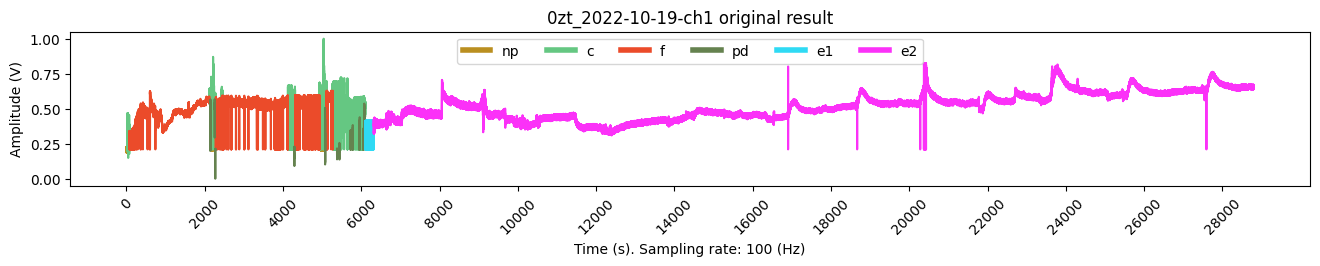

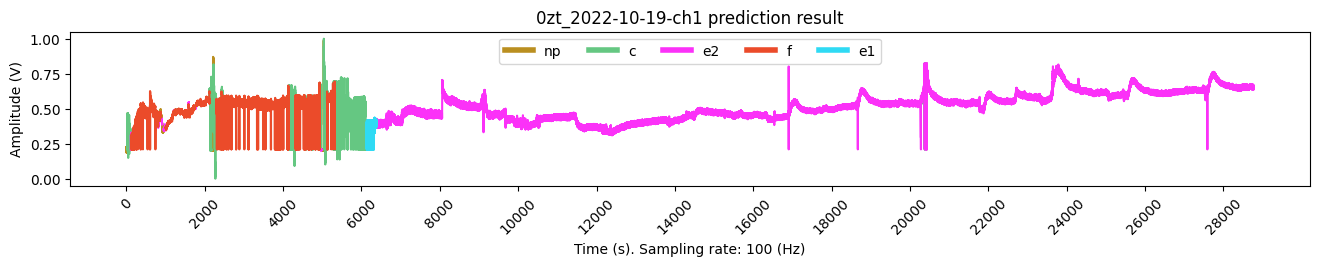

In [40]:
file = splits['0zt'][1][0]
wave_array,ana = data_test[file]

pred_ana = clf.predict(wave_array, ana, verbose = False)
clf.plot()

# Final comment

Our model use direct fft coefficients as input and it has given pretty promising results.

However, there are many further things to improve

- Data augmentation: We could try to oversample the short and minor class such as 'pd' to emphasizes this behavior
- There are noises in the signals that has to be considered, for example: 'np' waves should looks like a flat line but there are instances that 'np' waves amplitudes fluctuate arond 1V
- Our model has not taken into account the relation between waveforms. For example, you can only find 'pd' waves in between pathway 'c' waves, or 'e1' is usually followed up by 'e2', ...